<a href="https://colab.research.google.com/github/kk20krishna/X-ray-image-Classification/blob/main/X_ray_image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import kagglehub

# Download latest version
#path = kagglehub.dataset_download("kk20krishna/cxr-data")
path = kagglehub.dataset_download("nih-chest-xrays/data/images_001")

print("Path to dataset files:", path)

ValueError: Invalid dataset handle: nih-chest-xrays/data/images_001

In [ ]:
# List the contents of the dataset folder
dataset_files = os.listdir(path)
print("Files in dataset folder:", dataset_files)

In [ ]:
import shutil
import os

def gather_images(source_folders, destination_folder):
  """Moves all image files from source folders to the destination folder.

  Args:
    source_folders: A list of source folder paths.
    destination_folder: The destination folder path.
  """
  if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

  for source_folder in source_folders:
    if not os.path.exists(source_folder):
      print(f"Warning: Source folder '{source_folder}' not found.")
      continue

    for filename in os.listdir(source_folder):
      source_path = os.path.join(source_folder, filename)
      if os.path.isfile(source_path) and (filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))):
        destination_path = os.path.join(destination_folder, filename)
        try:
            shutil.move(source_path, destination_path)
            print(f"Moved '{filename}' to '{destination_folder}'")
        except shutil.Error as e:
            print(f"Error moving '{filename}': {e}")
        except OSError as e:
          print(f"OS Error moving '{filename}': {e}")



Moved '00000001_000.png' to 'data'
Moved '00000001_001.png' to 'data'
Moved '00000001_002.png' to 'data'
Moved '00000002_000.png' to 'data'


In [ ]:
source_folders = ["CXR/images_001",
                  "CXR/images_002",
                  ]
destination_folder = "data"
gather_images(source_folders, destination_folder)

In [ ]:
data_entry = pd.read_csv('/content/Data_Entry_2017.csv')
print(data_entry .head())

        Image Index Finding Labels
0  00000001_000.png   Cardiomegaly
1  00000001_001.png   Cardiomegaly
2  00000001_002.png   Cardiomegaly
3  00000002_000.png     No Finding
4  00000003_000.png         Hernia


In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
import pandas as pd
import shutil


def move_images(data_entry, image_dir, destination_dir):
    """Moves images to folders based on labels in the data_entry file.

    Args:
        data_entry: DataFrame with 'Image Index' and 'Finding Labels' columns.
        image_dir: Directory containing the images.
        destination_dir: Directory to store the organized images.
    """

    total_files_read = 0
    total_files_moved = 0
    label_counts = {}

    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    for index, row in data_entry.iterrows():
        image_name = row['Image Index']
        labels = row['Finding Labels'].split("|")
        total_files_read += 1

        image_path = os.path.join(image_dir, image_name)
        if os.path.exists(image_path):
          for label in labels:
              print(label)
              label_dir = os.path.join(destination_dir, label)

              if not os.path.exists(label_dir):
                  os.makedirs(label_dir)

              destination_path = os.path.join(label_dir, image_name)
              try:
                  #shutil.copy2(image_path, destination_path)  # Use copy2 to preserve metadata
                  shutil.move(image_path, destination_path)
                  total_files_moved += 1
                  label_counts[label] = label_counts.get(label, 0) + 1
                  break  # Move to the first label only
              except shutil.Error as e:
                  print(f"Error moving '{image_name}': {e}")
              except OSError as e:
                  print(f"OS Error moving '{image_name}': {e}")


    print(f"Total files read: {total_files_read}")
    print(f"Total files moved: {total_files_moved}")
    print("Files moved per label:")
    for label, count in label_counts.items():
        print(f"- {label}: {count}")


Cardiomegaly
Cardiomegaly
Cardiomegaly
No Finding
Total files read: 5
Total files moved: 4
Files moved per label:
- Cardiomegaly: 3
- No Finding: 1


In [ ]:
data_entry = pd.read_csv('/content/Data_Entry_2017.csv')
image_dir = '/content/data' # Replace with actual image directory
destination_dir = '/content/organized_data' # Replace with desired destination directory

move_images(data_entry.head(), image_dir, destination_dir)

In [ ]:
# Create a zip file of the organized data
!zip -r /content/organized_data.zip /content/organized_data

# Upload to Kaggle
!kaggle datasets init -p /content
!kaggle datasets create -p /content

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
train_dataset, val_dataset = keras.utils.image_dataset_from_directory(path,
                                                   label_mode='categorical',
                                                   validation_split=0.8,
                                                   subset="both",
                                                   image_size=(224, 224),
                                                   seed=44,)

In [ ]:
import numpy as np

class_counts = np.zeros(len(train_dataset.class_names))
for images, labels in train_dataset:
    for label in labels:
        class_counts[np.argmax(label)] += 1

print(class_counts)

total_samples = np.sum(class_counts)
class_weights = {}
for i, count in enumerate(class_counts):
    class_weights[i] = total_samples / (len(train_dataset.class_names) * count)

print("Class Weights:", class_weights)

In [ ]:
# prompt: get ResNet50V2, exclude top, freeze all layers, flatten, add two dense layers, add final layer with 2 outputs and softmax activation

from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# Load the pre-trained ResNet50V2 model without the top classification layer
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# Create the new model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model (you can adjust the optimizer, loss, and metrics)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC', 'precision', 'recall'])

# Print the model summary to see the architecture
model.summary(show_trainable=True)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_7          │ (None, 224, 224, 3)  │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv1_pad              │ (None, 230, 230, 3)  │            0 │ input_layer_7[0][0] │    -    │
│ (ZeroPadding2D)        │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv1_conv (Conv2D)    │ (None, 112, 112, 64) │        9,472 │ conv1_pad[0][0]     │    N    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ pool1_pad              │ (None, 114, 114, 64) │            0 │ conv1_conv[0][0]    │    -    │
│ (ZeroPadding2D)        │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ pool1_pool             │ (None, 56, 56, 64)   │            0 │ pool1_pad[0][0]     │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_preact_bn │ (None, 56, 56, 64)   │          256 │ pool1_pool[0][0]    │    N    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_preact_r… │ (None, 56, 56, 64)   │            0 │ conv2_block1_preac… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_1_conv    │ (None, 56, 56, 64)   │        4,096 │ conv2_block1_preac… │    N    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_1_bn      │ (None, 56, 56, 64)   │          256 │ conv2_block1_1_con… │    N    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_1_relu    │ (None, 56, 56, 64)   │            0 │ conv2_block1_1_bn[… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_2_pad     │ (None, 58, 58, 64)   │            0 │ conv2_block1_1_rel… │    -    │
│ (ZeroPadding2D)        │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_2_conv    │ (None, 56, 56, 64)   │       36,864 │ conv2_block1_2_pad… │    N    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_2_bn      │ (None, 56, 56, 64)   │          256 │ conv2_block1_2_con… │    N    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_2_relu  

 Total params: 126,852,098 (483.90 MB)

 Trainable params: 103,287,298 (394.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
model.fit(train_dataset, epochs=2, validation_data=val_dataset, class_weight=class_weights)

Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 264s 41s/step - accuracy: 0.5224 - loss: 3604.6543 - val_accuracy: 0.9107 - val_loss: 208.5247
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 259s 40s/step - accuracy: 0.4813 - loss: 1751.9517 - val_accuracy: 0.9107 - val_loss: 457.0417


class_names:  ['effusion', 'nofinding']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
predictions:  [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


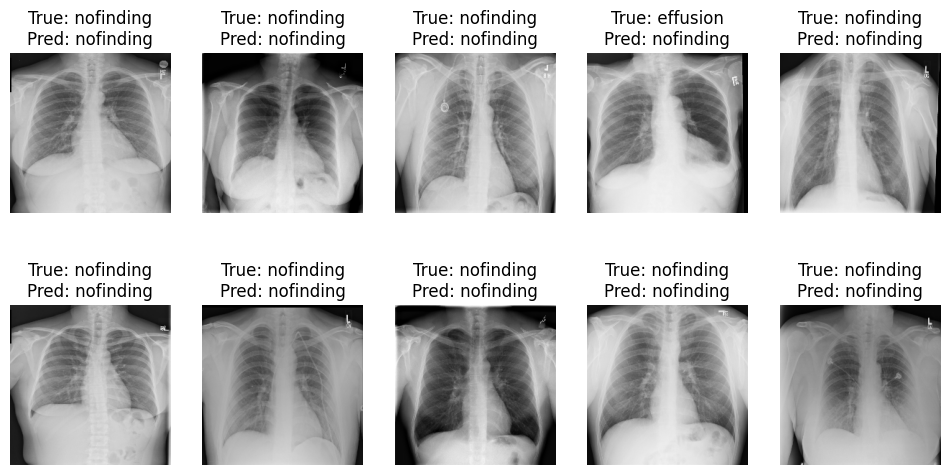

In [ ]:
# Define class names from dataset
class_names = val_dataset.class_names  # Get class labels from dataset
print("class_names: ", class_names)

# Take 10 images from val_dataset
num_images = 10
for images, labels in val_dataset.take(1):  # Take one batch
    images = images[:num_images]  # Select first 10 images
    labels = labels[:num_images]  # Corresponding labels

    # Make predictions
    predictions = model.predict(images)  # Get predicted probabilities
    print("predictions: ", predictions)
    predicted_classes = np.argmax(predictions, axis=1)  # Convert to class index
    true_classes = np.argmax(labels.numpy(), axis=1)  # Convert one-hot labels to index

    # Display images, true labels, and predicted labels
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)  # Arrange in 2 rows of 5 images
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[true_classes[i]]}\nPred: {class_names[predicted_classes[i]]}")
        plt.axis("off")  # Hide axes

    plt.show()